In [1]:
#https://medium.com/@mortenhegewald/marketing-channel-attribution-using-markov-chains-101-in-python-78fb181ebf1e

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import subprocess

Matplotlib is building the font cache using fc-list. This may take a moment.


In [2]:
# Load in our data
df = pd.read_csv('Channel_attribution.csv')

# Grab list of columns to iterate through
cols = df.columns

In [3]:
# Iterate through columns to change all ints to str and remove any trailing '.0'
for col in cols:
    df[col] = df[col].astype(str)
    df[col] = df[col].map(lambda x: str(x)[:-2] if '.' in x else str(x))

# Create a total path variable
df['Path'] = ''
for i in df.index:
    #df.at[i, 'Path'] = 'Start'
    for x in cols:
        df.at[i, 'Path'] = df.at[i, 'Path'] + df.at[i, x] + ' > '

In [4]:
# Split path on conversion (channel 21)
df['Path'] = df['Path'].map(lambda x: x.split(' > 21')[0])

# Create conversion value we can sum to get total conversions for each path
df['Conversion'] = 1

In [7]:
df.head(6)

,R05A.01,R05A.02,R05A.03,R05A.04,R05A.05,R05A.06,R05A.07,R05A.08,R05A.09,R05A.10,...,R05A.14,R05A.15,R05A.16,R05A.17,R05A.18,R05A.19,R05A.20,Output,Path,Conversion
0,16,4,3,5,10,8,6,8,13,20,...,nan,nan,nan,nan,nan,nan,nan,nan,16 > 4 > 3 > 5 > 10 > 8 > 6 > 8 > 13 > 20,1
1,2,1,9,10,1,4,3,21,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,2 > 1 > 9 > 10 > 1 > 4 > 3,1
2,9,13,20,16,15,21,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,9 > 13 > 20 > 16 > 15,1
3,8,15,20,21,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,8 > 15 > 20,1
4,16,9,13,20,21,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,16 > 9 > 13 > 20,1
5,1,11,8,4,9,21,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,1 > 11 > 8 > 4 > 9,1


In [8]:
# Select relevant columns
df = df[['Path', 'Conversion']]

# Sum conversions by Path
df = df.groupby('Path').sum().reset_index()

# Write DF to CSV to be executed in R
df.to_csv('Paths.csv', index=False)

In [11]:
# Run Markov Model R code
!Rscript Markov.R

Loading required package: ChannelAttribution
Warning message:
package ‘ChannelAttribution’ was built under R version 3.4.4 


In [15]:
# Load in the CSV file with the model output from R
markov = pd.read_csv('Markov - Output - Conversion values.csv')

# Select only the necessary columns and rename them
markov = markov[['channel_name', 'total_conversions']]
markov.columns = ['Channel', 'Conversion']

In [16]:
# First Touch Attribution
df['First Touch'] = df['Path'].map(lambda x: x.split(' > ')[0])
df_ft = pd.DataFrame()
df_ft['Channel'] = df['First Touch']
df_ft['Attribution'] = 'First Touch'
df_ft['Conversion'] = 1
df_ft = df_ft.groupby(['Channel', 'Attribution']).sum().reset_index()

In [17]:
# Last Touch Attribution
df['Last Touch'] = df['Path'].map(lambda x: x.split(' > ')[-1])
df_lt = pd.DataFrame()
df_lt['Channel'] = df['Last Touch']
df_lt['Attribution'] = 'Last Touch'
df_lt['Conversion'] = 1
df_lt = df_lt.groupby(['Channel', 'Attribution']).sum().reset_index()

In [18]:
# Linear Attribution
channel = []
conversion = []
for i in df.index:
    for j in df.at[i, 'Path'].split(' > '):
        channel.append(j)
        conversion.append(1/len(df.at[i, 'Path'].split(' > ')))
lin_att_df = pd.DataFrame()
lin_att_df['Channel'] = channel
lin_att_df['Attribution'] = 'Linear'
lin_att_df['Conversion'] = conversion
lin_att_df = lin_att_df.groupby(['Channel', 'Attribution']).sum().reset_index()

In [19]:
# Concatenate the four data frames to a single data frame
df_total_attr = pd.concat([df_ft, df_lt, lin_att_df, markov])
df_total_attr['Channel'] = df_total_attr['Channel'].astype(int)
df_total_attr.sort_values(by='Channel', ascending=True, inplace=True)

//anaconda/envs/consumer_finance/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


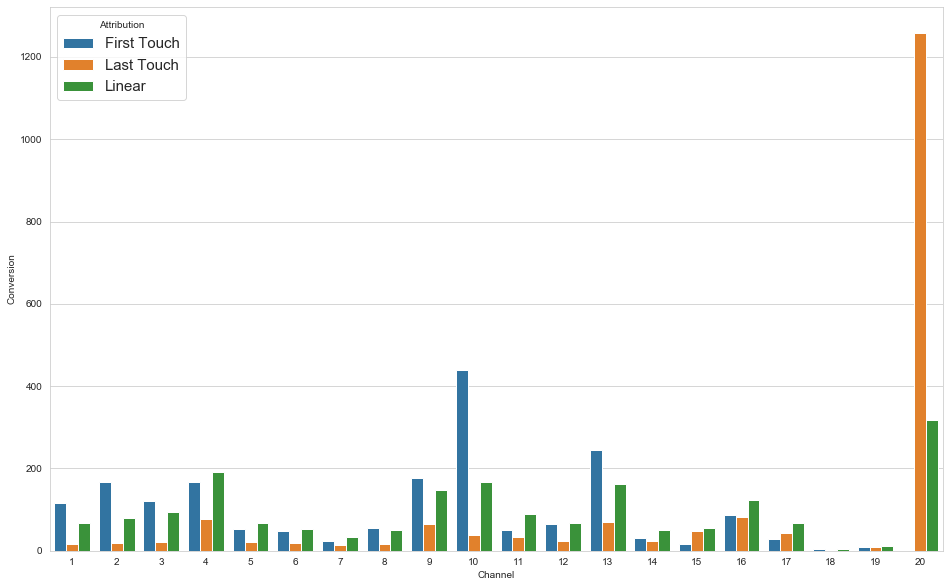

In [20]:
# Visualize the attributions
sns.set_style("whitegrid")
plt.rc('legend', fontsize=15)
fig, ax = plt.subplots(figsize=(16, 10))
sns.barplot(x='Channel', y='Conversion', hue='Attribution', data=df_total_attr)
plt.show()

In [21]:
# Read in transition matrix CSV
trans_prob = pd.read_csv('Markov - Output - Transition matrix.csv')

# Convert data to floats
trans_prob ['transition_probability'] = trans_prob ['transition_probability'].astype(float)

# Convert start and conversion event to numeric values so we can sort and iterate through
trans_prob .replace('(start)', '0', inplace=True)
trans_prob .replace('(conversion)', '21', inplace=True)

In [22]:
# Get unique origin channels
channel_from_unique = trans_prob ['channel_from'].unique().tolist()
channel_from_unique.sort(key=float)

# Get unique destination channels
channel_to_unique = trans_prob ['channel_to'].unique().tolist()
channel_to_unique.sort(key=float)

In [23]:
# Create new matrix with origin and destination channels as columns and index
trans_matrix = pd.DataFrame(columns=channel_to_unique, index=channel_from_unique)

# Assign the probabilities to the corresponding cells in our transition matrix
for f in channel_from_unique:
    for t in channel_to_unique:
        x = trans_prob [(trans_prob ['channel_from'] == f) & (trans_prob ['channel_to'] == t)]
        prob = x['transition_probability'].values
        if prob.size > 0:
            trans_matrix[t][f] = prob[0]
        else:
            trans_matrix[t][f] = 0

In [24]:
# Convert all probabilities to floats
trans_matrix = trans_matrix.apply(pd.to_numeric)

# Rename our start and conversion events
trans_matrix.rename(index={'0': 'Start'}, inplace=True)
trans_matrix.rename(columns={'21': 'Conversion'}, inplace=True)

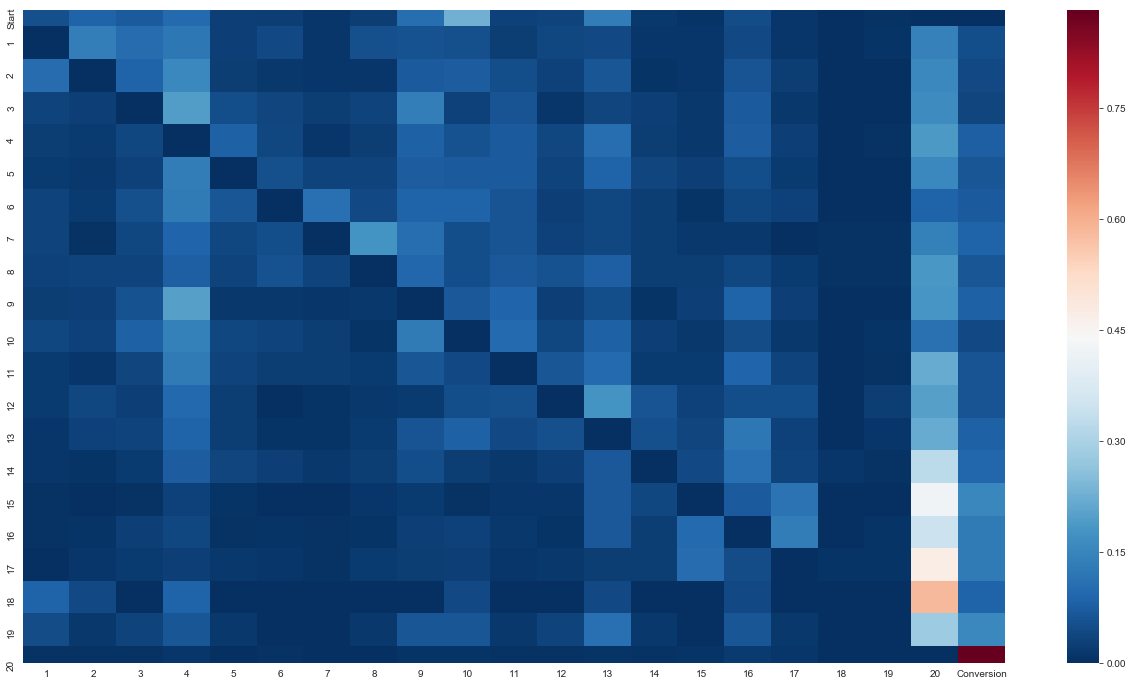

In [25]:
# Visualize this transition matrix in a heatmap
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(22, 12))
sns.heatmap(trans_matrix, cmap="RdBu_r")
plt.show()